In [1]:
import os

from matplotlib import cm
from matplotlib.colors import Normalize
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from deepcell_tracking.metrics import calculate_summary_stats

In [2]:
baxter_path = '../benchmarking/Baxter/benchmarks.csv'
embedtrack_path = '../benchmarking/EmbedTrack/benchmarks.csv'
deepcell_path = '../benchmarking/DeepCell/benchmarks.csv'

In [3]:
# EmbedTrack data
et_df = pd.read_csv(embedtrack_path, index_col=0)
et_df['model'] = 'EmbedTrack ' + et_df['model']
# Rollup data for each model version
et_df = et_df.groupby('model').sum().drop(columns=['data_id']).reset_index()

In [4]:
# Baxter data
b_df = pd.read_csv(baxter_path, index_col=0)
b_df = b_df.groupby('model').sum().drop(columns=['data_id']).reset_index()

In [5]:
dc_df = pd.read_csv(deepcell_path, index_col=0)
dc_df = dc_df.groupby('model').sum().drop(columns=['data_id']).reset_index()

# Plots

In [6]:
df = pd.concat([et_df, b_df, dc_df]).reset_index(drop=True)

In [7]:
df

,model,correct_division,mismatch_division,false_positive_division,false_negative_division,total_divisions,aa_tp,aa_total,te_tp,te_total
0,EmbedTrack Fluo-N2DH-GOWT1,0,0,9,108,108,5846,29912,6232,30658
1,EmbedTrack Fluo-N2DH-SIM+,0,4,1495,174,178,25316,49272,26444,50485
2,EmbedTrack Fluo-N2DL-HeLa,121,7,365,50,178,43925,49272,45108,50485
3,Baxter - Deepcell,89,6,48,83,178,48035,49272,49222,50485
4,Baxter - GT,111,7,22,60,178,48349,49272,49540,50485
5,Deepcell - Deepcell,128,29,16,21,178,47139,48562,48659,49775
6,Deepcell - GT,168,2,3,8,178,48132,48562,49402,49775


In [8]:
def calculate_stats(row):
    cols = ['correct_division', 'false_positive_division', 'false_negative_division', 'total_divisions',
            'aa_tp', 'aa_total', 'te_tp', 'te_total']
    d = row[cols].to_dict()
    return pd.Series(calculate_summary_stats(**d))

In [9]:
df = df.join(df.apply(calculate_stats, axis=1))

In [10]:
stats_columns = ['Division Precision', 'Division Recall', 'Division F1', 'Mitotic branching correctness', 'Association Accuracy',
       'Target Effectiveness']
stats = df[['model']+stats_columns].melt(
    id_vars='model',
    value_vars=stats_columns,
    var_name='metric'
    )
div_columns = ['correct_division', 'mismatch_division', 'false_positive_division', 'false_negative_division']
divisions = df[['model']+div_columns].melt(
    id_vars='model',
    value_vars=div_columns,
    var_name='metric'
    )

In [11]:
# Norm for tab20 colormap
norm = Normalize(vmin=0, vmax=19)

# GT segs are even numbers
colors = {
    'Baxter - GT': cm.tab20(norm(0)),
    'Baxter - Deepcell': cm.tab20(norm(1)),
    'Deepcell - GT': cm.tab20(norm(2)),
    'Deepcell - Deepcell': cm.tab20(norm(3)),
    'EmbedTrack Fluo-N2DH-GOWT1': cm.tab20(norm(5)),
    'EmbedTrack Fluo-N2DH-SIM+': cm.tab20(norm(7)),
    'EmbedTrack Fluo-N2DL-HeLa': cm.tab20(norm(9))
}

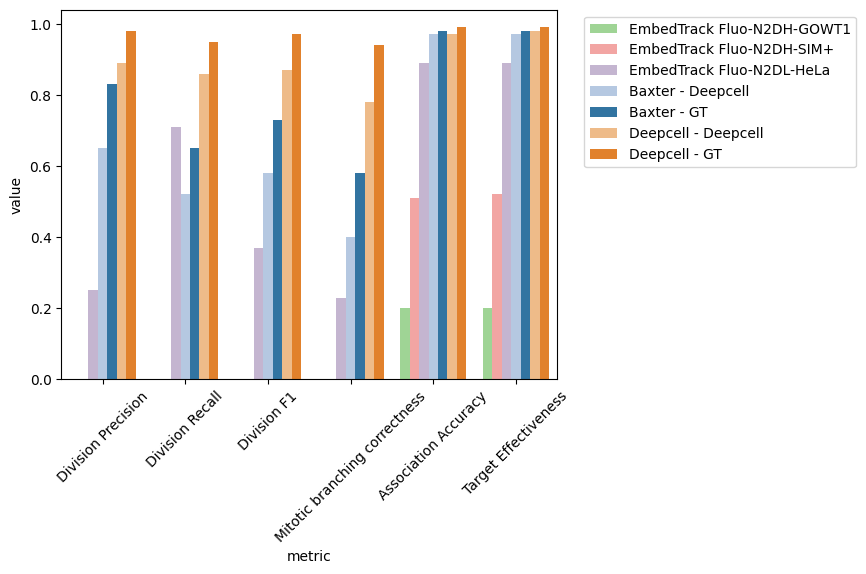

In [12]:
sns.barplot(
    data=stats,
    x='metric',
    y='value',
    hue='model',
    palette=colors
)
plt.xticks(rotation=45)
plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")